In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qnmfits
import funcs.CCE as CCE
from funcs.likelihood_funcs import * 
from funcs.utils import *
from funcs.kernel_param_funcs import *
from funcs.qnm_selecting_funcs import *
import corner
import scipy
import pickle 

In [2]:
ID = "0001" 

In [3]:
# Noise data for CCE sims 

with open('tuned_params.pkl', 'rb') as f:
    tuned_params = pickle.load(f)

tuned_params_lm = tuned_params[ID]

with open('param_dict_sim_lm_full.pkl', 'rb') as f:
    params = pickle.load(f)

with open('R_dict_sim_lm_full.pkl', 'rb') as f:
    R = pickle.load(f)

In [4]:
# This is just for the white noise kernel because I don't auto generate a file 

with open('param_dict_sim_lm_full.pkl', 'rb') as f:
    param_dict_sim_lm = pickle.load(f)

tuning_hyperparams_s = [0.3996582031249995]  

hyperparam_rule_dict_s = {
    "sigma_max": "multiply",
}

tuned_param_dict_wn = {mode: get_new_params(param_dict_sim_lm[ID][mode], tuning_hyperparams_s, hyperparam_rule_dict_s) for mode in param_dict_sim_lm[ID]}

Set up all parameters for minimal working example 

In [5]:
TRAINING_TIME_STEP = 0.1 
TRAINING_T0 = -10
TRAINING_T = 100

training_times = np.arange(
    TRAINING_T0, TRAINING_T0 + TRAINING_T, TRAINING_TIME_STEP
)
######################################################################################################

# Based on ls fit of 0001 

DATA_AMPS = [0.4, 0.2, -0.04, -0.2]

DATA_QNMS = [(2, 2, 0, 1), (2, 2, 1, 1)]
DATA_SPHERICAL_MODES = [(2, 2)]
sim_main = CCE.SXS_CCE(ID, lev="Lev5", radius="R2")
DATA_MASS = sim_main.Mf
DATA_SPIN = sim_main.chif_mag 

DATA_TIME_STEP = 0.1
DATA_TIME_STEP_DOWNSAMPLED = 0.5

DATA_T0 = -10 # This needs to be consistent with training start (can't start arbitrarily far back)
DATA_T = 100

data_times = np.arange(
    DATA_T0, DATA_T0 + DATA_T, DATA_TIME_STEP
)

data_times_downsampled = np.arange(
    DATA_T0, DATA_T0 + DATA_T, DATA_TIME_STEP_DOWNSAMPLED
)

####################################################################################################

ANALYSIS_TIME_STEP = 0.1
ANALYSIS_T0 = 10
ANALYSIS_T = 100

analysis_times = np.arange(
    ANALYSIS_T0, ANALYSIS_T0 + ANALYSIS_T, ANALYSIS_TIME_STEP
)

MODEL = [(2,2,0,1), (2,2,1,1)]
SPH_MODES = [(2,2)]

####################################################################################################

MOCK_TUNING_PARAMS  = [1, 0, 0.5, 3]


In [ ]:
SIMNUMS = [
    "0001"
]

SIM_TRAINING_MODE_RULES = {
    "0001": "PE"
}

SMOOTHNESS = 16
EPSILON = 1 / 10

INITIAL_PARAMS = [1, 0, 0.5, 3]

SIGMA_MAX_LOWER, SIGMA_MAX_UPPER = 0.1, 2
T_S_LOWER, T_S_UPPER = -10, 10
LENGTH_SCALE_LOWER, LENGTH_SCALE_UPPER = 0.1, 5
PERIOD_LOWER, PERIOD_UPPER = 0.1, 5

BOUNDS = [
    (SIGMA_MAX_LOWER, SIGMA_MAX_UPPER),
    (T_S_LOWER, T_S_UPPER),
    (LENGTH_SCALE_LOWER, LENGTH_SCALE_UPPER),
    (PERIOD_LOWER, PERIOD_UPPER),
]

HYPERPARAM_RULE_DICT = {
    "sigma_max": "multiply",
    "t_s": "sum",
    "length_scale": "multiply",
    "period": "multiply",
}



In [ ]:
SIMNUMS = [
    "0001"
]

SIM_TRAINING_MODE_RULES = {
    "0001": "PE"
}

SMOOTHNESS = 16
EPSILON = 1 / 10

INITIAL_PARAMS_S = [1]

SIGMA_MAX_LOWER, SIGMA_MAX_UPPER = 0.1, 2

BOUNDS_S = [
    (SIGMA_MAX_LOWER, SIGMA_MAX_UPPER),
]

HYPERPARAM_RULE_DICT_S = {
    "sigma_max": "multiply",
}

Functions to get mock data and noise

In [7]:
# Get mock data with noise functions

def get_mock_data(times, t0, amps, qnm_list, spherical_modes, mass, spin):
    mock_data = {mode: np.zeros_like(times, dtype=complex) for mode in spherical_modes}
    for i, qnm in enumerate(qnm_list):
        amp = amps[2 * i] + 1j * amps[2 * i + 1]
        omega = qnmfits.qnm.omega(*qnm, spin, Mf=mass)
        for ell, m in spherical_modes:
            mu = qnmfits.qnm.mu(ell, m, qnm[0], qnm[1], qnm[2], qnm[3], spin)
            mock_data[ell, m] += amp * mu * np.exp(-1j * omega * (times - t0))
    return mock_data

def get_noisy_mock_data(mock_data, kernel_dict, times):
    data = mock_data.copy()
    rng = np.random.default_rng()
    repeats = 1
    noise = {mode: np.zeros_like(times, dtype=complex) for mode in mock_data.keys()}
    for ell, m in data.keys():
        gp_samples = rng.multivariate_normal(np.zeros(len(times)), kernel_dict[ell,m], size=repeats)
        for j, draw in enumerate(gp_samples):
            data[ell, m] += draw
            noise[ell, m] += draw
    return data, noise

In [8]:
mock_tuned_params_main_lm = get_tuned_params(
    params[ID], MOCK_TUNING_PARAMS, HYPERPARAM_RULE_DICT
)

In [9]:
mock_kernel_dict = {
    mode: compute_kernel_matrix(data_times, mock_tuned_params_main_lm[mode], kernel_main)
    for mode in mock_tuned_params_main_lm.keys()
}

mock_h = get_mock_data(data_times, DATA_T0, DATA_AMPS, DATA_QNMS, DATA_SPHERICAL_MODES, DATA_MASS, DATA_SPIN)
data, noise = get_noisy_mock_data(mock_h, mock_kernel_dict, data_times)

data_downsampled = sim_interpolator_data(data, data_times, data_times_downsampled)

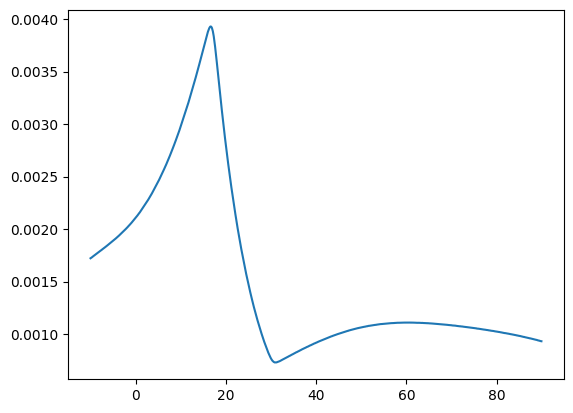

In [10]:
plt.plot(data_times, np.real(noise[2,2]), label="Re")

In [11]:
R = {'0001': noise}

In [12]:
hyperparam_list, le = get_minimised_hyperparams(
    INITIAL_PARAMS,
    BOUNDS,
    params,
    R,
    HYPERPARAM_RULE_DICT,
    training_times,
    kernel_main,
    SPH_MODES,
    SIM_TRAINING_MODE_RULES,
)

print(
    "Optimal parameters:",
    dict(zip(HYPERPARAM_RULE_DICT.keys(), hyperparam_list)),
    "Log evidence:",
    le,
)

Optimal parameters: {'sigma_max': 0.6032952482647871, 't_s': -1.8530984626385356e-05, 'length_scale': 0.49999025962166255, 'period': 3.0561431535579304} Log evidence: -54894.58354845099


In [ ]:
hyperparam_list_s, le = get_minimised_hyperparams(
    INITIAL_PARAMS_S,
    BOUNDS_S,
    params,
    R,
    HYPERPARAM_RULE_DICT_S,
    training_times,
    kernel_main,
    SPH_MODES,
    SIM_TRAINING_MODE_RULES,
)

print(
    "Optimal parameters:",
    dict(zip(HYPERPARAM_RULE_DICT_S.keys(), hyperparam_list)),
    "Log evidence:",
    le,
)

In [14]:
tuned_params_lm = get_tuned_params(params[ID], MOCK_TUNING_PARAMS, HYPERPARAM_RULE_DICT)

In [15]:
ls_fit = qnmfits.multimode_ringdown_fit(
    data_times,
    data,
    modes=MODEL,
    Mf=DATA_MASS,
    chif=DATA_SPIN,
    t0=ANALYSIS_T0,
    T=ANALYSIS_T,
    spherical_modes=SPH_MODES,
)
 
C_0 = ls_fit["C"]

true_params = []
for re_c, im_c in zip(np.real(ls_fit["C"]), np.imag(ls_fit["C"])):
    true_params.append(re_c)
    true_params.append(im_c)

In [16]:
# White noise kernel

fit_wn = qnm_BGP_fit(
        data_times,
        data,
        MODEL,
        DATA_MASS,
        DATA_SPIN,
        ANALYSIS_T0,
        tuned_param_dict_wn,
        kernel_s,
        t0_method="geq",
        T=ANALYSIS_T,
        spherical_modes=SPH_MODES,
    )


fit_wn_downsampled = qnm_BGP_fit(
        data_times_downsampled,
        data_downsampled,
        MODEL,
        DATA_MASS,
        DATA_SPIN,
        ANALYSIS_T0,
        tuned_param_dict_wn,
        kernel_s,
        t0_method="geq",
        T=ANALYSIS_T,
        spherical_modes=SPH_MODES,
    )

# Standard kernel 

fit_main = qnm_BGP_fit(
        data_times,
        data,
        MODEL,
        DATA_MASS,
        DATA_SPIN,
        ANALYSIS_T0,
        tuned_params_lm,
        kernel_main,
        t0_method="geq",
        T=ANALYSIS_T,
        spherical_modes=SPH_MODES,
    )

fit_main_downsampled = qnm_BGP_fit(
        data_times_downsampled,
        data_downsampled,
        MODEL,
        DATA_MASS,
        DATA_SPIN,
        ANALYSIS_T0,
        tuned_params_lm,
        kernel_main,
        t0_method="geq",
        T=ANALYSIS_T,
        spherical_modes=SPH_MODES,
)

In [17]:
cond_number = np.linalg.cond(fit_main['covariance'])
print(f"Condition number: {cond_number}")

cond_number = np.linalg.cond(fit_main_downsampled['covariance'])
print(f"Condition number: {cond_number}")

Condition number: 41.04752952150752
Condition number: 35.80932674304341


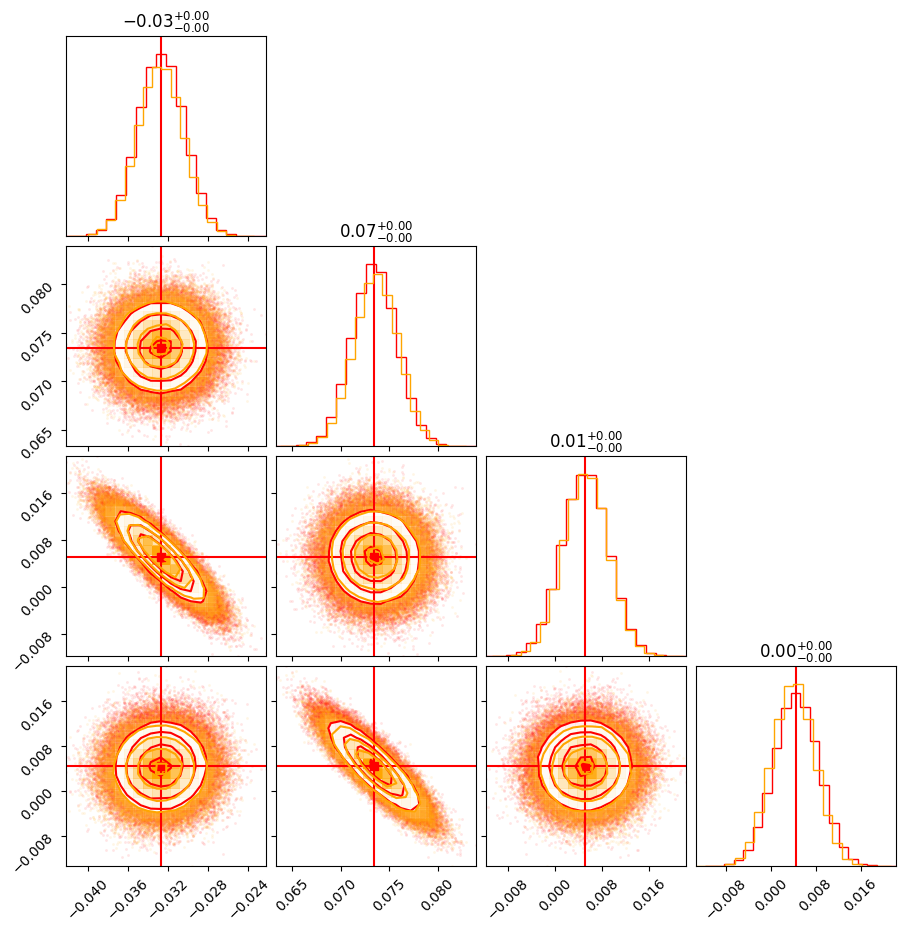

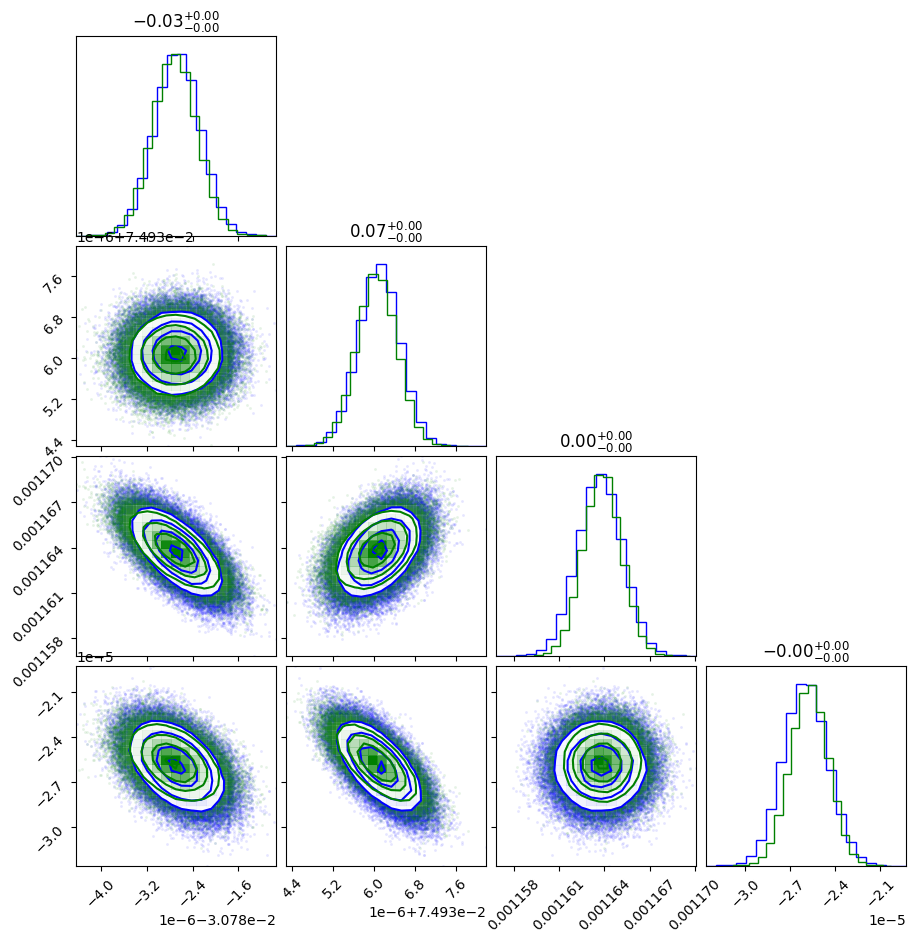

In [18]:
samples_s = scipy.stats.multivariate_normal(fit_wn['mean'], fit_wn['covariance'], allow_singular=True).rvs(
    size=100000
)

samples_s_downsampled = scipy.stats.multivariate_normal(fit_wn_downsampled['mean'], fit_wn_downsampled['covariance'], allow_singular=True).rvs(
    size=100000
)


samples = scipy.stats.multivariate_normal(fit_main['mean'], fit_main['covariance'], allow_singular=True).rvs(
    size=100000
)

samples_downsampled = scipy.stats.multivariate_normal(fit_main_downsampled['mean'], fit_main_downsampled['covariance'], allow_singular=True).rvs(
    size=100000
)

figure = corner.corner(
    samples_s,
    truths=true_params,
    color='red',
    truth_color='red',
    label_kwargs={"fontsize": 12},
    show_titles=True,
    title_kwargs={"fontsize": 12}
)

figure = corner.corner(
    samples_s_downsampled,
    color='orange',
    fig=figure,
    label_kwargs={"fontsize": 12},
    show_titles=True,
    title_kwargs={"fontsize": 12}
)

figure = corner.corner(
    samples,
    color='blue',
    truths=DATA_AMPS,
    truth_color='blue',
    #fig=figure,
    label_kwargs={"fontsize": 12},
    show_titles=True,
    title_kwargs={"fontsize": 12}
) 

figure = corner.corner(
    samples_downsampled,
    color='green',
    truth_color='green',
    fig=figure,
    label_kwargs={"fontsize": 12},
    show_titles=True,
    title_kwargs={"fontsize": 12}
)


plt.show()